## Given Parameters

In [1]:
import numpy as np
import math
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
day_to_sec = 24 * 60 * 60
d_to_m2 = 1.02e-12

params = {
    'dx': {'00': 450, '01': 220, '10': 450, '11': 220},       # m
    'dy': {'00': 300, '01': 300, '10': 250, '11': 250},       # m
    'dz': {'00': 30, '01': 30, '10': 30, '11': 30},           # m
    'phi': {'00': 0.25, '01': 0.09, '10': 0.18, '11': 0.11},  # Unit
    'k': {'00': 0.005, '01': 0.02, '10': 0.01, '11': 0.035},  # D
    'q_star': {'00': 0 / day_to_sec,                          # m^3 / d
               '01': 37 / day_to_sec,
               '10': -25 / day_to_sec,
               '11': 0 / day_to_sec,
         }
}

ct = 1e-9         # 1 / Pa
mu = 0.0025       # Pa * sec
p_init = 27e6     # Pa

## Task 1

Set up and write down the equations for explicit and implicit schemes in a general form. 
Write  down  equations  for  computing  transmissibility  in  x  and  y  directions  in  a  general 
form.

---

### Explicit scheme

$$ T_{i+1/2,j}(P_{i+1,j}^n-P_{i,j}^n)-T_{i-1/2,j}(P_{i,j}^n-P_{i-1,j}^n)+T_{i,j+1/2}(P_{i,j+1}^n-P_{i,j}^n)-T_{i,j-1/2}(P_{i,j}^n-P_{i,j-1}^n)=\frac{c\phi_{i,j} V_{bi,j}}{\Delta t}(P_{i,j}^{n+1}-P_{i,j}^n)+\zeta_{i,j}, $$
where
$$ \zeta_{i,j}=T_{i+1/2,j}\rho g(D_{i+1,j}-D_{i,j})-T_{i-1/2,j}\rho g(D_{i,j}-D_{i-1,j})+
T_{i,j+1/2}\rho g(D_{i,j+1}-D_{i,j})-T_{i,j-1/2}\rho g(D_{i,j}-D_{i,j-1})- q_{i,j}^* $$

Equation for pressure:
$$ P_{i,j}^{n+1}=P_{i,j}^n+\frac{\Delta t}{c\phi_{i,j} V_{bi,j}}\left[T_{i+1/2,j}(P_{i+1,j}^n-P_{i,j}^n)-T_{i-1/2,j}(P_{i,j}^n-P_{i-1,j}^n)+T_{i,j+1/2}(P_{i,j+1}^n-P_{i,j}^n)-T_{i,j-1/2}(P_{i,j}^n-P_{i,j-1}^n)-\zeta_{i,j}\right], $$
$$ t_0 = 0, t_1 = \Delta t, t_2 = t_1 + \Delta t_2 \ldots  $$


**Stability**
$$ \Delta t \le \frac{c \phi_{i,j} V_{bi,j}}{T_{i+1/2,j}+T_{i-1/2,j}+T_{i,j+1/2}+T_{i,j-1/2}} $$

---

### Implicit scheme

$$ T_{i+1/2,j}(P_{i+1,j}^{n+1}-P_{i,j}^{n+1})-T_{i-1/2,j}(P_{i,j}^{n+1}-P_{i-1,j}^{n+1})+T_{i,j+1/2}(P_{i,j+1}^{n+1}-P_{i,j}^{n+1})-T_{i,j-1/2}(P_{i,j}^{n+1}-P_{i,j-1}^{n+1})=\frac{c\phi_{i,j} V_{bi,j}}{\Delta t}(P_{i,j}^{n+1}-P_{i,j}^n)+\zeta_{i,j}, $$
where
$$ \zeta_{i,j}=T_{i+1/2,j}\rho g(D_{i+1,j}-D_{i,j})-T_{i-1/2,j}\rho g(D_{i,j}-D_{i-1,j})+
T_{i,j+1/2}\rho g(D_{i,j+1}-D_{i,j})-T_{i,j-1/2}\rho g(D_{i,j}-D_{i,j-1})- q_{i,j}^* $$

Equation for unknown pressures:
$$ P_{i-1, j}^{n+1} T_{i-1/2, j} + P_{i, j-1}^{n+1} T_{i, j-1/2} - P_{i, j}^{n+1} \bigg(T_{i+1/2, j} + T_{i-1/2, j} + T_{i, j+1/2} + T_{i, j-1/2} + \frac{c \phi_{i, j} V_{bi, j}}{\Delta t}\bigg) + P_{i+1, j}^{n+1} T_{i+1/2, j} + P_{i, j+1}^{n+1} T_{i, j+1/2} = \zeta_{i,j} - P_{i, j}^{n} \frac{c \phi_{i, j} V_{bi, j}}{\Delta t} $$

One can introduce coefficients $A, B, C, D, E, F$:

$$ A = T_{i-1/2, j}, B = T_{i, j-1/2}, C = -\bigg(T_{i+1/2, j} + T_{i-1/2, j} + T_{i, j+1/2} + T_{i, j-1/2} + \frac{c \phi_{i, j} V_{bi, j}}{\Delta t}\bigg), $$

$$ D = T_{i+1/2, j}, E = T_{i, j+1/2}, F = \zeta_{i,j} - P_{i, j}^{n} \frac{c \phi_{i, j} V_{bi, j}}{\Delta t}. $$

Then for cell $i, j$ one can get: 

$$ A^{i, j} P_{i-1, j}^{n+1} + B^{i, j} P_{i, j-1}^{n+1} + C^{i, j} P_{i, j}^{n+1} + D^{i, j} P_{i+1, j}^{n+1} + E^{i, j} P_{i, j+1}^{n+1} = F^{i, j} $$

----
### Transmissibility

For 2D flows the transmissibility for horizontal flows is the following:
$$ T_{i+1/2, j}=\frac{ 2 A_{i,j}k_{i,j}A_{i+1,j}k_{i+1,j} }{ A_{i,j}k_{i,j}\Delta x_{i+1,j}+
                                                                A_{i+1,j}k_{i+1,j}\Delta x_{i,j} } \frac{1}{\mu} $$
and for vertical flows:
$$ T_{i, j+1/2}=\frac{ 2 A_{i,j}k_{i,j}A_{i,j+1}k_{i,j+1} }{ A_{i,j}k_{i,j}\Delta y_{i,j+1}+
                                                                A_{i,j+1}k_{i,j+1}\Delta y_{i,j} } \frac{1}{\mu} $$


$$ [T] = \frac{m^2 \cdot D \cdot m^2 \cdot D}{m^2 \cdot D \cdot m} \cdot \frac{1}{Pa \cdot sec} = m \cdot D \cdot \frac{1}{Pa \cdot sec} = m \cdot m^2 \cdot \frac{1}{Pa \cdot sec} = \frac{m^3}{Pa \cdot sec}$$

## Task 2

Write  down  the  values  for  transmissibility  in  x  and  y  directions  in  case  of  Neumann 
boundary  conditions.  Please,  explain  the  difference  between  Dirichlet  and  Neumann 
boundary conditions using the Figure 1.  

---

**The Dirichlet (first-type) boundary condition.** It specifies the values that a solution needs to take along the boundary of the domain. For our case (fluid mechanics) one consider **pressure equal to zero at the boundaries**.

**The Neumann (second-type) boundary condition.** It specifies the values that a derivative of solution needs to take along the boundary of the domain. For our case (fluid mechanics) one consider **flow equal to zero at the boundaries**.

*P.S.:* by *boundary* I consider the outer boundary of computational grid.

#### Values of Transmissibilities at the Boundaries Between Cells ((i,j),(k,r)):

$$ T_{00, 01} = \frac{2(30 \cdot 300)(30 \cdot 300) \cdot 0.005 \cdot 1.02 \cdot 10^{-12} \cdot 0.02 \cdot 1.02 \cdot 10^{-12}}{(30 \cdot 300) \cdot 0.005 \cdot 1.02 \cdot 10^{-12} \cdot 220 + (30 \cdot 300) \cdot 0.02 \cdot 1.02 \cdot 10^{-12} \cdot 450} \frac{1}{0.0025} = 7.273 \cdot 10^{-11} \space \frac{m^3}{Pa \cdot sec} $$

$$ T_{01, 11} = \frac{2(30 \cdot 220)(30 \cdot 220) \cdot 0.02 \cdot 1.02 \cdot 10^{-12} \cdot 0.035 \cdot 1.02 \cdot 10^{-12}}{(30 \cdot 220) \cdot 0.02 \cdot 1.02 \cdot 10^{-12} \cdot 250 + (30 \cdot 220) \cdot 0.035 \cdot 1.02 \cdot 10^{-12} \cdot 300} \frac{1}{0.0025} = 2.433 \cdot 10^{-10} \space \frac{m^3}{Pa \cdot sec} $$

$$ T_{11, 10} = \frac{2(30 \cdot 250)(30 \cdot 250) \cdot 0.035 \cdot 1.02 \cdot 10^{-12} \cdot 0.01 \cdot 1.02 \cdot 10^{-12}}{(30 \cdot 250) \cdot 0.035 \cdot 1.02 \cdot 10^{-12} \cdot 450 + (30 \cdot 250) \cdot 0.01 \cdot 1.02 \cdot 10^{-12} \cdot 220} \frac{1}{0.0025} = 1.194 \cdot 10^{-10} \space \frac{m^3}{Pa \cdot sec} $$

$$ T_{10, 00} = \frac{2(30 \cdot 450)(30 \cdot 450) \cdot 0.01 \cdot 1.02 \cdot 10^{-12} \cdot 0.005 \cdot 1.02 \cdot 10^{-12}}{(30 \cdot 450) \cdot 0.01 \cdot 1.02 \cdot 10^{-12} \cdot 300 + (30 \cdot 450) \cdot 0.005 \cdot 1.02 \cdot 10^{-12} \cdot 250} \frac{1}{0.0025} = 1.296 \cdot 10^{-10} \space \frac{m^3}{Pa \cdot sec} $$

In [3]:
t_00_01 = 2 * (30 * 300) ** 2 * 0.005 * d_to_m2 * 0.02 * d_to_m2 / (30 * 300 * 0.005 * d_to_m2* 220 + 30 * 300 * 0.02 * d_to_m2 * 450) / 0.0025
t_01_11 = 2 * (30 * 220) ** 2 * 0.02 * d_to_m2 * 0.035 * d_to_m2 / (30 * 220 * 0.02 * d_to_m2 * 250 + 30 * 220 * 0.035 * d_to_m2 * 300) / 0.0025
t_11_10 = 2 * (30 * 250) ** 2 * 0.035 * d_to_m2 * 0.01 * d_to_m2 / (30 * 250 * 0.035 * d_to_m2 * 450 + 30 * 250 * 0.01 * d_to_m2 * 220) / 0.0025
t_10_00 = 2 * (30 * 450) ** 2 * 0.01 * d_to_m2 * 0.005 * d_to_m2 / (30 * 450 * 0.01 * d_to_m2 * 300 + 30 * 450 * 0.005 * d_to_m2 * 250) / 0.0025
print('t_00_01', t_00_01)
print('t_01_11', t_01_11)
print('t_11_10', t_11_10)
print('t_10_00', t_10_00)

t_00_01 7.271287128712872e-11
t_01_11 2.432206451612903e-10
t_11_10 1.1933147632311977e-10
t_10_00 1.2960000000000002e-10


## Task 3

Compute ∆𝑡 for stability of the explicit scheme in case of Neumann boundary conditions. 



In [4]:
def stable_t(c, phi, V, T):
    dt = c * phi * V / np.asarray(T).sum() / day_to_sec
#     return np.round(dt, 2)
    return math.floor(dt)

In [5]:
dt_00 = stable_t(1e-9, params['phi']['00'],
                 params['dx']['00']*params['dy']['00']*params['dz']['00'],
                 [t_00_01, t_10_00])

dt_10 = stable_t(1e-9, params['phi']['10'],
                 params['dx']['10']*params['dy']['10']*params['dz']['10'],
                 [t_11_10, t_10_00])

dt_01 = stable_t(1e-9, params['phi']['01'],
                 params['dx']['01']*params['dy']['01']*params['dz']['01'],
                 [t_00_01, t_01_11])

dt_11 = stable_t(1e-9, params['phi']['11'],
                 params['dx']['11']*params['dy']['11']*params['dz']['11'],
                 [t_01_11, t_11_10])

dt = np.min([dt_00, dt_11, dt_10, dt_01])

print(f'For cell 00 dt is {dt_00}.\nFor cell 11 dt is {dt_11}.\nFor cell 01 dt is {dt_01}.\nFor cell 10 dt is {dt_10}.\n Minimum dt is {dt}.')

For cell 00 dt is 57.
For cell 11 dt is 5.
For cell 01 dt is 6.
For cell 10 dt is 28.
 Minimum dt is 5.


## Task 4

Assuming Neumann boundary conditions, implement function that calculates the pressure 
distribution  over  time  for  all  cells  (depicted  in  the  Figure  1)  using  explicit  scheme  until 
time 𝑡=250 days. Choose two different timestamps:  

1. ∆𝑡=5  days 

2. ∆𝑡=15 days 

In [6]:
class FlowSimulator():
    def __init__(self, dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt):
        self.dx = dx
        self.dy = dy
        self.dz = dz
        self.phi = phi
        self.k = k
        self.q_star = q_star
        self.ct = ct
        self.mu = mu
        self.pressure = p_init
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.rho = rho
        self.g = g
        self.dt = dt
        self.results = self.pressure.ravel()
        self.day_to_sec = 24 * 3600
        
    def Transm(self, i, j):
        '''Returns transmissibility of the current cell with all
           conjuate cells.
           The order: (i-1,j); (i+1, j); (i, j-1), (i, j+1)'''
        
        transm = np.zeros(4)
        
        if i == 0:
            transm[0] = 0
            
            numerator = 2 * self.dx[i, j] * self.dz[i, j] * self.k[i, j] * self.dx[i+1, j] * self.dz[i+1, j] * self.k[i+1, j]
            denomenator = self.dx[i, j] * self.dz[i, j] * self.k[i, j] * self.dy[i+1, j] + self.dx[i+1, j] * self.dz[i+1, j] * self.k[i+1, j] * self.dy[i, j]
            
            transm[1] = numerator / denomenator / self.mu[i, j]
            
        elif i == (self.x_dim - 1):
            transm[1] = 0
            
            numerator = 2 * self.dx[i, j] * self.dz[i, j] * self.k[i, j] * self.dx[i-1, j] * self.dz[i-1, j] * self.k[i-1, j]
            denomenator = self.dx[i, j] * self.dz[i, j] * self.k[i, j] * self.dy[i-1, j] + self.dx[i-1, j] * self.dz[i-1, j] * self.k[i-1, j] * self.dy[i, j]
            
            transm[0] = numerator / denomenator / self.mu[i, j]
        
        if j == 0:
            transm[2] = 0
            
            numerator = 2 * self.dy[i, j] * self.dz[i, j] * self.k[i, j] * self.dy[i, j+1] * self.dz[i, j+1] * self.k[i, j+1]
            denomenator = self.dy[i, j] * self.dz[i, j] * self.k[i, j] * self.dx[i, j+1] + self.dy[i, j+1] * self.dz[i, j+1] * self.k[i, j+1] * self.dx[i, j]
            
            transm[3] = numerator / denomenator / self.mu[i, j]
            
        elif j == (self.y_dim - 1):
            transm[3] = 0
            
            numerator = 2 * self.dy[i, j] * self.dz[i, j] * self.k[i, j] * self.dy[i, j-1] * self.dz[i, j-1] * self.k[i, j-1]
            denomenator = self.dy[i, j] * self.dz[i, j] * self.k[i, j] * self.dx[i, j-1] + self.dy[i, j-1] * self.dz[i, j-1] * self.k[i, j-1] * self.dx[i, j]
            
            transm[2] = numerator / denomenator / self.mu[i, j]
            
        return transm
        
#     def Zeta(self, i, j, transm):
#         '''Returns zeta coefficient for the current cell with all
#            conjuate cells.
#            The order: (i-1,j); (i+1, j); (i, j-1), (i, j+1)'''
        
#         if i == 0:
#             multiplier = transm[1] * (self.dy[i+1, j])
            
#         elif i == (self.x_dim - 1):
        
#         if i == 0:
#             multiplier = transm[1] * (self.dy[i, j] + self.dy[i+1, j] / 2 - self.dy[i, j] / 2)
            
#         elif i == (self.x_dim - 1):
#             multiplier = -transm[0] * (self.dy[i, j] + self.dy[i+1, j] / 2 - self.dy[i, j] / 2) 

#         zeta = self.rho * self.g * multiplier - self.q_star[i, j]
#         return -self.q_star[i, j]
    
    def Pressure_ij_explicit(self, i, j):        
        transm = self.Transm(i, j)
        zeta = -self.q_star[i, j]
    
        coeff = self.dt * self.day_to_sec / (self.ct[i, j] * self.phi[i, j] * self.dx[i, j] * self.dy[i, j] * self.dz[i, j])
        multiplier = 0
        
        if i == 0:
            multiplier += transm[1] * (self.pressure[i+1, j] - self.pressure[i, j])
        elif i == (self.x_dim - 1):
            multiplier -= transm[0] * (self.pressure[i, j] - self.pressure[i-1, j])
            
        if j == 0:
            multiplier += transm[3] * (self.pressure[i, j+1] - self.pressure[i, j])
        elif j == (self.y_dim - 1):
            multiplier -= transm[2] * (self.pressure[i, j] - self.pressure[i, j-1])
        
        multiplier -= zeta
        p_curr_ij = self.pressure[i, j] + coeff * multiplier

        return p_curr_ij
    
    def Stable_dt(self):
        dt_min = []
        
        for i in range(self.x_dim):
            for j in range(self.y_dim):
                dt_stable = math.floor(self.ct[i, j] * self.phi[i, j] * self.dx[i, j] * self.dy[i, j] * self.dz[i, j] / self.Transm(i, j).sum() / self.day_to_sec)
                print(f'  For cell i={i}, j={j}: {dt_stable}')
                
                dt_min.append(dt_stable)

        dt_min = np.min(dt_min)

        print(f'Min stable day interval: {dt_min}.')
        return
    
    def Explicit_scheme(self, t):
        n_steps = math.ceil(t / self.dt)
        
        for step in tqdm(range(n_steps)):
            pressure_new = np.zeros(self.pressure.shape)

            for i in range(self.x_dim):
                for j in range(self.y_dim):
                    pressure_new[i, j] = self.Pressure_ij_explicit(i, j)

            self.pressure = pressure_new
            self.results = np.vstack((self.results, self.pressure.ravel()))
            
    def Get_coeff_for_cell(self, i, j):
        transm = self.Transm(i, j)
        A, B, C, D, E = 0, 0, 0, 0, 0
        coeff_inv = (self.ct[i, j] * self.phi[i, j] * self.dx[i, j] * self.dy[i, j] * self.dz[i, j]) / (self.dt * self.day_to_sec)
        zeta = -self.q_star[i, j]
        
        if i == 0:
            A = 0
            C -= transm[1]
            D += transm[1]
        elif i == (self.x_dim - 1):
            D = 0
            A += transm[0]
            C -= transm[0]

        if j == 0:
            B = 0
            C -= transm[3]
            E += transm[3]
        elif j == (self.y_dim - 1):
            E = 0
            C -= transm[2]
            B += transm[2]
        
        C -= coeff_inv
        F = zeta - self.pressure[i, j] * coeff_inv
            
        return A, B, C, D, E, F
    
    def Get_param_matrix_vector(self, A, B, C, D, E, F):
        ''' It's a shame but I could not create a general term for this function.
            Order of cells: (0, 0), (0, 1), (1, 0), (1, 1).
        '''
        
        matrix_params = np.array([
            [C[0], E[0], D[0], 0],
            [B[1], C[1], 0, D[1]],
            [A[2], 0, C[2], E[2]],
            [0, A[3], B[3], C[3]]
        ])
        
        vector_params = np.array([F[0], F[1], F[2], F[3]])
        
        return matrix_params, vector_params
    
    def Implicit_scheme(self, t):
        n_steps = math.ceil(t / self.dt)
        for step in tqdm(range(n_steps)):
            pressure_new = np.zeros(self.pressure.shape)
            
            A, B, C, D, E, F = [], [], [], [], [], []
            
            for i in range(self.x_dim):
                for j in range(self.y_dim):
                    a, b, c, d, e, f = self.Get_coeff_for_cell(i, j)
                    A.append(a)
                    B.append(b)
                    C.append(c)
                    D.append(d)
                    E.append(e)
                    F.append(f)
                    
            coeff_matrix, vector_coeff = self.Get_param_matrix_vector(A, B, C, D, E, F)
            
            self.pressure = np.linalg.solve(coeff_matrix, vector_coeff).reshape((2, 2))
            self.results = np.vstack((self.results, self.pressure.ravel()))
    
    def Results(self, last_iter=True):
        if last_iter:
            return self.results[-1].reshape((self.x_dim, self.y_dim))
        else:
            return self.results
        
    def Material_balance(self, tol=1e-6):
        if self.results.shape[0] == 1:
            raise RuntimeError('No calculations were peformed.')
        
        n_steps = math.ceil(t / self.dt)
        MB = []
        
        if n_steps != 1:
            for step in tqdm(range(1, n_steps)):
                coeff = self.ct * self.phi * self.dx * self.dy * self.dz / self.dt
                mb = coeff.ravel() * (self.results[step, :] - self.results[step-1, :])
                mb = mb.sum() / self.q_star.sum()
                MB.append(mb)
        else:
            coeff = self.ct * self.phi * self.dx * self.dy * self.dz / self.dt
            mb = coeff.ravel() * (self.results[1, :] - self.results[0, :])
            mb = mb.sum() / self.q_star.sum()
            MB.append(mb)
        
        if (np.max(MB) - np.min(MB)) <= tol:
#             print('Material balance converge.')
            return 1
        else: 
#             print('You screwed up somewhere.')
            return 0

### Reintroduce grid parameters

In [7]:
d_to_m2 = 1.02e-12
day_to_sec = 24 * 60 * 60
x_dim = 2
y_dim = 2
rho = (1040 - 730) / 2     # Average oil density, kg / m ^ 3
g = 9.81
t = 250

dx = np.array([[450, 220], [450, 220]])
dy = np.array([[300, 300], [250, 250]])
dz = np.array([[30, 30], [30, 30]])

phi = np.array([[0.25, 0.09], [0.18, 0.11]])
k = np.array([[0.005, 0.02], [0.01, 0.035]]) * d_to_m2
q_star = np.array([[0, 37], [-25, 0]]) / day_to_sec

ct = np.array([[1e-9, 1e-9], [1e-9, 1e-9]])
mu = np.array([[0.0025, 0.0025], [0.0025, 0.0025]])
p_init = np.array([[27e6, 27e6], [27e6, 27e6]])

100%|██████████| 50/50 [00:00<00:00, 8361.52it/s]


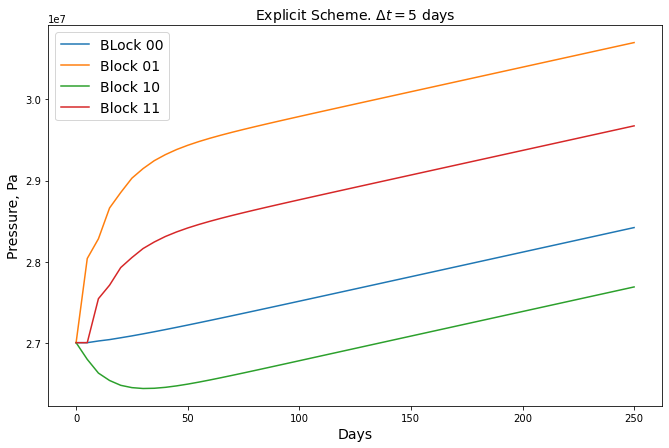

In [8]:
dt = 5

exp_scheme_dt5 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt)
exp_scheme_dt5.Explicit_scheme(250)

res = exp_scheme_dt5.Results(last_iter=False)

# print('final_pressure',  exp_scheme_dt5.Results())
plt.rcParams['figure.figsize'] = (11, 7)
abc = plt.plot(np.arange(math.ceil(t / dt)+1)*dt, res)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Pressure, Pa', fontsize=14)
plt.title('Explicit Scheme. $\Delta t = 5$ days', fontsize=14)
plt.legend(iter(abc), ['BLock 00', 'Block 01', 'Block 10', 'Block 11'], fontsize=14);

100%|██████████| 17/17 [00:00<00:00, 4220.37it/s]


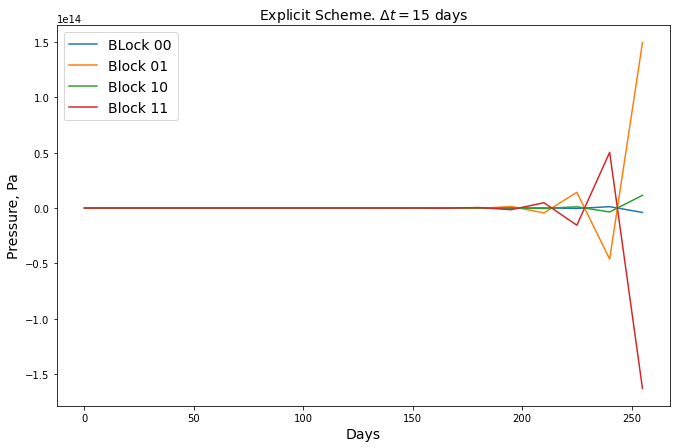

In [9]:
dt = 15

exp_scheme_dt5 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt)
exp_scheme_dt5.Explicit_scheme(250)

res = exp_scheme_dt5.Results(last_iter=False)

# print('final_pressure',  exp_scheme_dt5.Results())
plt.rcParams['figure.figsize'] = (11, 7)
abc = plt.plot(np.arange(math.ceil(t / dt)+ 1)*dt, res)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Pressure, Pa', fontsize=14)
plt.title('Explicit Scheme. $\Delta t = 15$ days', fontsize=14)
plt.legend(iter(abc), ['BLock 00', 'Block 01', 'Block 10', 'Block 11'], fontsize=14);

In [10]:
exp_scheme_dt5.Stable_dt()

  For cell i=0, j=0: 57
  For cell i=0, j=1: 6
  For cell i=1, j=0: 28
  For cell i=1, j=1: 5
Min stable day interval: 5.


## Task 5

Assuming Neumann boundary conditions, calculate the pressure distribution over time for 
all cells (depicted in the Figure 1) using implicit scheme until time 𝑡 = 250 days if: 

1. ∆𝑡=5  days 

2. ∆𝑡=15 days 

3. ∆𝑡=250 days  

---

Genreal form for $i, j$:

$$ A^{i, j} P_{i-1, j}^{n+1} + B^{i, j} P_{i, j-1}^{n+1} + C^{i, j} P_{i, j}^{n+1} + D^{i, j} P_{i+1, j}^{n+1} + E^{i, j} P_{i, j+1}^{n+1} = F^{i, j} $$

Our case (basically, its all the special cases from the general $n \times n$ grid):


$$ Cell (0, 0): \space 0 + 0 + C^{0, 0} P_{0, 0}^{n+1} + D^{0, 0} P_{1, 0}^{n+1} + E^{0, 0} P_{0, 1}^{n+1} = F^{0, 0} $$

$$ Cell (0, 1): \space 0 + B^{0, 1} P_{0, 0}^{n+1} + C^{0, 1} P_{0, 1}^{n+1} + D^{0, 1} P_{1, 1}^{n+1} + 0 = F^{0, 1} $$

$$ Cell (1, 0): \space A^{1, 0} P_{0, 0}^{n+1} + 0 + C^{1, 0} P_{1, 0}^{n+1} + 0 + E^{1, 0} P_{1, 1}^{n+1} = F^{1, 0} $$

$$ Cell (1, 1): \space A^{1, 1} P_{0, 1}^{n+1} + B^{1, 1} P_{1, 0}^{n+1} + C^{1, 1} P_{1, 1}^{n+1} + 0 + 0 = F^{1, 1} $$

I will try to write it in matrix form to identify the pattern for gathering a general-term matrix: 

P.S. Did not succeed :(

$$ C^{0, 0} P_{0, 0}^{n+1} + E^{0, 0} P_{0, 1}^{n+1} + D^{0, 0} P_{1, 0}^{n+1} + 0 = F^{0, 0} $$

$$ B^{0, 1} P_{0, 0}^{n+1} + C^{0, 1} P_{0, 1}^{n+1} + 0 + D^{0, 1} P_{1, 1}^{n+1}= F^{0, 1} $$

$$ A^{1, 0} P_{0, 0}^{n+1} + 0 + C^{1, 0} P_{1, 0}^{n+1} + E^{1, 0} P_{1, 1}^{n+1} = F^{1, 0} $$

$$ 0 + A^{1, 1} P_{0, 1}^{n+1} + B^{1, 1} P_{1, 0}^{n+1} + C^{1, 1} P_{1, 1}^{n+1} = F^{1, 1} $$

$$
\begin{bmatrix} A^{i, j} \\ B^{i, j} \\ C^{i, j} \\ D^{i, j} \\ E^{i, j} \end{bmatrix} ^ T
\begin{bmatrix} P_{i-1, j} \\ P_{i, j-1} \\ P_{i, j} \\ P_{i+1, j} \\ P_{i, j+1} \end{bmatrix} = F^{i, j}$$


$$
\begin{bmatrix}
C^{0, 0} & E^{0, 0} & D^{0, 0} & 0 \\
B^{0, 1} & C^{0, 1} & 0 & D^{0, 1} \\
A^{1, 0} & 0 & C^{1, 0} & E^{1, 0} \\
0 & A^{1, 1} & B^{1, 1} & C^{1, 1} \end{bmatrix}
\begin{bmatrix}
P^{n+1}_{0, 0} \\ P^{n+1}_{0, 1} \\ P^{n+1}_{1, 0} \\ P^{n+1}_{1, 1} \end{bmatrix} = 
\begin{bmatrix}
F^{0,0} \\ F^{0, 1} \\ F^{1, 0} \\ F^{1, 1} \end{bmatrix}
$$

100%|██████████| 50/50 [00:00<00:00, 7163.38it/s]


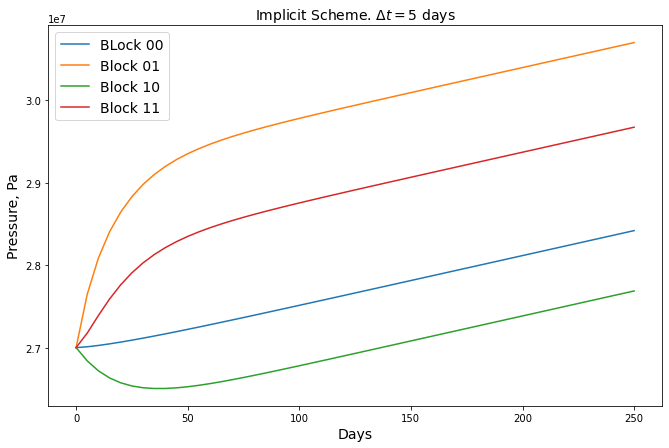

In [11]:
dt = 5

imp_scheme_dt5 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt)
imp_scheme_dt5.Implicit_scheme(250)

res = imp_scheme_dt5.Results(last_iter=False)

# print('final_pressure',  exp_scheme_dt5.Results())
plt.rcParams['figure.figsize'] = (11, 7)
abc = plt.plot(np.arange(math.ceil(t / dt)+ 1)*dt, res)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Pressure, Pa', fontsize=14)
plt.title('Implicit Scheme. $\Delta t = 5$ days', fontsize=14)
plt.legend(iter(abc), ['BLock 00', 'Block 01', 'Block 10', 'Block 11'], fontsize=14);

100%|██████████| 17/17 [00:00<00:00, 4293.82it/s]


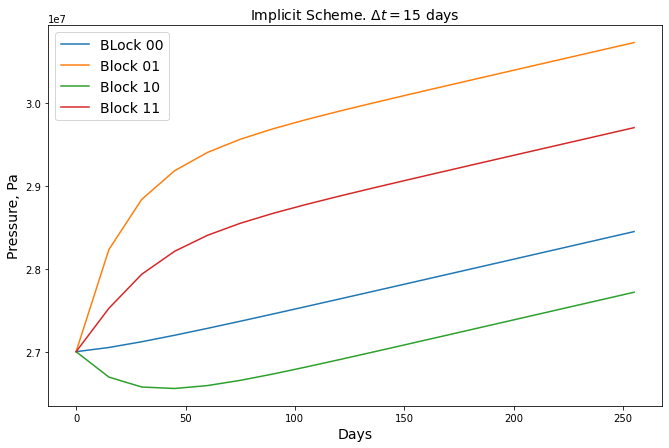

In [12]:
dt = 15

imp_scheme_dt15 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt)
imp_scheme_dt15.Implicit_scheme(250)

res = imp_scheme_dt15.Results(last_iter=False)

# print('final_pressure',  exp_scheme_dt5.Results())
plt.rcParams['figure.figsize'] = (11, 7)
abc = plt.plot(np.arange(math.ceil(t / dt)+ 1)*dt, res)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Pressure, Pa', fontsize=14)
plt.title('Implicit Scheme. $\Delta t = 15$ days', fontsize=14)
plt.legend(iter(abc), ['BLock 00', 'Block 01', 'Block 10', 'Block 11'], fontsize=14);

100%|██████████| 1/1 [00:00<00:00, 501.41it/s]


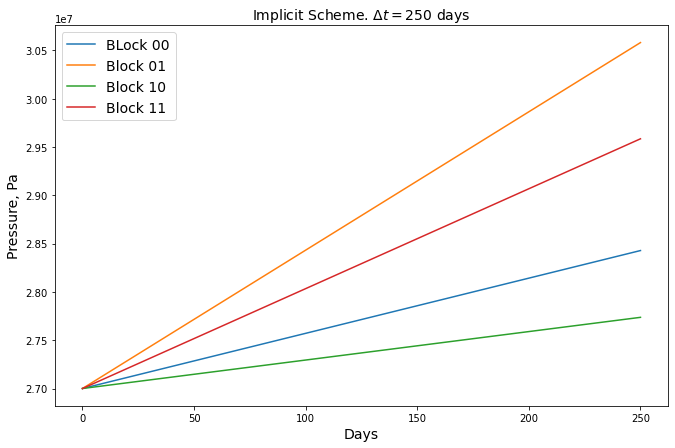

In [13]:
dt = 250

imp_scheme_dt250 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt)
imp_scheme_dt250.Implicit_scheme(250)

res = imp_scheme_dt250.Results(last_iter=False)

# print('final_pressure',  exp_scheme_dt5.Results())
plt.rcParams['figure.figsize'] = (11, 7)
abc = plt.plot(np.arange(math.ceil(t / dt)+ 1)*dt, res)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Pressure, Pa', fontsize=14)
plt.title('Implicit Scheme. $\Delta t = 250$ days', fontsize=14)
plt.legend(iter(abc), ['BLock 00', 'Block 01', 'Block 10', 'Block 11'], fontsize=14);

## Task 6

Assuming Neumann boundary conditions perform Material Balance check in each of the 
above cases and comment on stability of the solution when comparing the explicit versus 
implicit scheme.

In [14]:
dt5 = 5
dt15 = 15
dt250 = 250

exp_scheme_dt5 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt5)
exp_scheme_dt5.Explicit_scheme(250)

exp_scheme_dt15 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt15)
exp_scheme_dt15.Explicit_scheme(250)

imp_scheme_dt5 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt5)
imp_scheme_dt5.Implicit_scheme(250)

imp_scheme_dt15 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt15)
imp_scheme_dt15.Implicit_scheme(250)

imp_scheme_dt250 = FlowSimulator(dx, dy, dz, phi, k, q_star, ct, mu, p_init, x_dim, y_dim, rho, g, dt250)
imp_scheme_dt250.Implicit_scheme(250)

models = [exp_scheme_dt5, exp_scheme_dt15, imp_scheme_dt5, imp_scheme_dt15, imp_scheme_dt250]
model_names = ['Explicit, dt=5', 'Explicit, dt=15', 'Implicit, dt=5', 'Implicit, dt=15', 'Implicit, dt=250']
for m, n in zip(models, model_names):
    if m.Material_balance() == 1:
        print(f'For model:{n}\nmaterial balance converges.\n')
    elif m.Material_balance() == -1:
        print(f'For model:{n}\nCannot check material balance for 1 step calculations.')
    else:
        print(f'For model:{n}\nmaterial balance does NOT converge.\n')

100%|██████████| 16/16 [00:00<?, ?it/s]

For model:Explicit, dt=5
material balance converges.

For model:Explicit, dt=15
material balance does NOT converge.

For model:Implicit, dt=5
material balance converges.

For model:Implicit, dt=15
material balance converges.

For model:Implicit, dt=250
material balance converges.



#### It happens as it supposed to: explicit method converges only with appropriate time steps; implicit is unconditionally stable.